# <span style="color:red">Homework Solution 2</span>

## FINM 37400 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

# 1 HBS Case: Fixed-Income Arbitrage in a Financial Crisis (A): US Treasuries in November 2008

## Data
* Use the data file `treasury_ts_2015-08-15.xlsx`.
* Examine the treasure issues with `kytreasno` of `204046` and `204047`. These are the bond and note (respectively) which mature on 2015-08-15.
* Look at the data on 2008-11-04.

## 1.1 The situation

Make a chart comparing the issues in the following features, (as of Nov 4, 2008.)
* coupon rate
* bid
* ask
* accrued interest
* dirty price
* duration (quoted in years, not days, assuming 365.25 days per year.)
* modified duration
* YTM

## 1.2 Hedge Ratio

Suppose you are building a trade to go long $n_i$ bonds (`204046`) and short $n_j$ notes (`204047`).

We can find an equation for $n_j$ in terms of $n_i$ such that the total holdings will have duration equal to zero. (Having zero duration also means have zero dollar duration, if helpful.)

Notation:
* $n_i$: number of bonds purchased (or sold)
* $D_i$: duration of bond $i$
* $D_{\$,i}$: dollar duration of bond $i$, equal to $p_iD_i$

If we want the total duration of our holdings to be zero, then we need to size the trade such that $n_i$ and $n_j$ satisfy,

$$0 = n_iD_{\$,i} + n_jD_{\$,j}$$

$$n_j = -n_i\frac{D_{\$,i}}{D_{\$,j}}$$

Suppose you will use \\$1mm of capital, leveraged 50x to buy \\$50mm of the bonds (`204046`).

Use the ratio above to short a number of notes (`204047`) to keep zero duration.

Report the number of bonds and notes of your position, along with the total dollars in the short position.

## 1.3 Profit Opportunity

Using the concept of **modified duration**, how much profit or loss (PnL) would you expect to make for every basis point of convergence in the spread? Specifically, assume the convergence is symmetric: the bond's (`204046`) ytm goes down 0.5bp and the note (`204047`) ytm goes up 0.5bp.

Describe the PnL you would expect to achieve on your position should this happen. Specify the PnL of the long position, the short position, and the net total.

Suppose the spread in YTM between the two securities disappears, due to a symmetric move of roughly ~17bps in each security's YTM. What is the PnL? (This is just a linearly scaling of your prior answer for a 1bp convergence.) 


## 1.4 Result in 2008

Calculate the profit (or loss) on the position on the following two dates:
* 2008-11-25
* 2008-12-16

To calculate the pnl on each date, simply use the prices of the securities on those dates along with your position sizes, ($n_i, n_j$). No coupon is being paid in November or December, so all you need is the "dirty" price on these two dates.

Does the pnl make sense (approximately) given your results in 1.3 with regard to the sensitivity of pnl to moves in the YTM spread?

## 1.5 Examining the Trade through June 2009

Calculate the pnl of the trade for the following dates:
* 2009-01-27
* 2009-03-24
* 2009-06-16

Did the trade do well or poorly in the first six months of 2009?

Calculate the YTM spreads on these dates. Does the YTM spread correspond to pnl roughly as we would expect based on the calculation in 1.3?

***

# <span style="color:red">Solution 1</span>

See separate notebook discussing the case.

***

***

# 2 Hedging Duration

Import `treasury_ts_issue_duration_(207392, 207391, 207404).xlsx`.

I suggest using code such as

* `tsdata = pd.read_excel(filepath_tsdata,sheet_name='ts')`

* `tsdata.columns = tsdata.columns.str.upper()`

* `px = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDASK').dropna()`
* `duration = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDDURATN').dropna()`

## 2.1 

Suppose you have a portfolio of 10,000 USD long in security `207391` on the last day of the sample.

If you want to manage interest rate exposure using duration, how large of a short position should you hold in `207392`?

(Duration is the column `TDDURATN` in the raw data.)

## 2.2

Step through the time-series, doing the following:

* Starting at the end of the first day, set the hedged position according to the relative given durations.
* Use the second day's price data to evaluate the net profit or loss of the hedged position.
* Reset the the hedged position using the end-of-second-day durations. Again fix the long position of security `207391` to be 10,000.
* Repeat throughout the timeseries.

Report 
* the total profit (or loss.)
* the mean, standard deviation, min, and max of the daily profit or loss.

***

# <span style="color:red">Solution 2</span>

In [9]:
filepath_tsdata = '../data/treasury_ts_issue_duration_(207392, 207391, 207404).xlsx'

info = pd.read_excel(filepath_tsdata,sheet_name='info').set_index('kytreasno')
info

,issue date,maturity date,coupon rate,security type
kytreasno,,,,
207392,2019-08-15,2049-08-15,2.250,1
207391,2019-08-15,2029-08-15,1.625,2
207404,2019-08-31,2024-08-31,1.250,2


In [10]:
SIZE = 10000
IDLONG = 207391
IDSHORT = 207392

FREQ = 365.25

In [11]:
tsdata = pd.read_excel(filepath_tsdata,sheet_name='ts')
tsdata.columns = tsdata.columns.str.upper()
px = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDASK').dropna()
duration = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDDURATN').dropna()/FREQ

In [12]:
position = pd.DataFrame(index=duration.index, dtype=float)

position['long'] = SIZE / px[IDLONG]
position['hedge ratio'] = (duration[IDLONG] / duration[IDSHORT]) * (px[IDLONG] / px[IDSHORT])
position['short'] = - position['hedge ratio'] * position['long']
position[['long ($)','short ($)']] = position[['long','short']] * px[[IDLONG,IDSHORT]].values

position['net ($)'] = position[['long ($)','short ($)']].sum(axis=1)
wts = position[['long ($)','short ($)']].div(position[['long ($)','short ($)']].sum(axis=1),axis=0)

### Check that duration is indeed hedged as of end of day

In [13]:
position['duration'] = (wts * duration[[IDLONG,IDSHORT]].values).sum(axis=1)
position['duration'].describe().to_frame().T.style.format('{:.1%}')

,count,mean,std,min,25%,50%,75%,max
duration,106700.0%,-0.0%,0.0%,-0.0%,-0.0%,0.0%,0.0%,0.0%


### Based on position at end of $t$, calculate  profit & loss at $t+1$

Note that this is not the true **profit** given that we are ignoring the coupons.

In [14]:
position[['long ($) realized','short ($) realized']] = \
    position[['long','short']] * px[[IDLONG,IDSHORT]].shift(-1).values

position[['long p&l','short p&l']] = \
    position[['long ($) realized','short ($) realized']] - position[['long ($)','short ($)']].values

position['profit hedged'] = position[['long p&l','short p&l']].sum(axis=1)

### Compare to profit of holding position unhedged

In [15]:
position['profit'] = px[IDLONG].diff() * position['long'].shift()

position

,long,hedge ratio,short,long ($),short ($),net ($),duration,long ($) realized,short ($) realized,long p&l,short p&l,profit hedged,profit
CALDT,,,,,,,,,,,,,
2019-08-29,98.811178,0.395113,-39.041629,10000.0,-4156.713467,5843.286533,0.000000e+00,9998.456075,-4157.933518,-1.543925,-1.220051,-2.763976,NaN
2019-08-30,98.826436,0.394841,-39.020756,10000.0,-4155.710484,5844.289516,-1.776357e-15,10039.376158,-4164.551124,39.376158,-8.840640,30.535518,-1.543925
2019-09-03,98.438822,0.395185,-38.901579,10000.0,-4151.831759,5848.168241,0.000000e+00,9991.540414,-4136.635829,-8.459586,15.195929,6.736343,39.376158
2019-09-04,98.522167,0.396512,-39.065237,10000.0,-4154.038590,5845.961410,-1.776357e-15,9914.562808,-4082.317257,-85.437192,71.721333,-13.715859,-8.459586
2019-09-05,99.371167,0.401225,-39.870191,10000.0,-4166.434955,5833.565045,-1.776357e-15,10000.000000,-4187.615994,0.000000,-21.181039,-21.181039,-85.437192
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-24,116.469518,0.420077,-48.926183,10000.0,-3091.523203,6908.476797,2.664535e-15,10040.036397,-3128.217840,40.036397,-36.694637,3.341759,-25.412961
2023-11-27,116.005075,0.415096,-48.153189,10000.0,-3078.794551,6921.205449,0.000000e+00,10049.845931,-3098.356784,49.845931,-19.562233,30.283698,40.036397
2023-11-28,115.429705,0.413743,-47.758175,10000.0,-3072.940070,6927.059930,-1.776357e-15,10045.089729,-3112.862920,45.089729,-39.922849,5.166879,49.845931


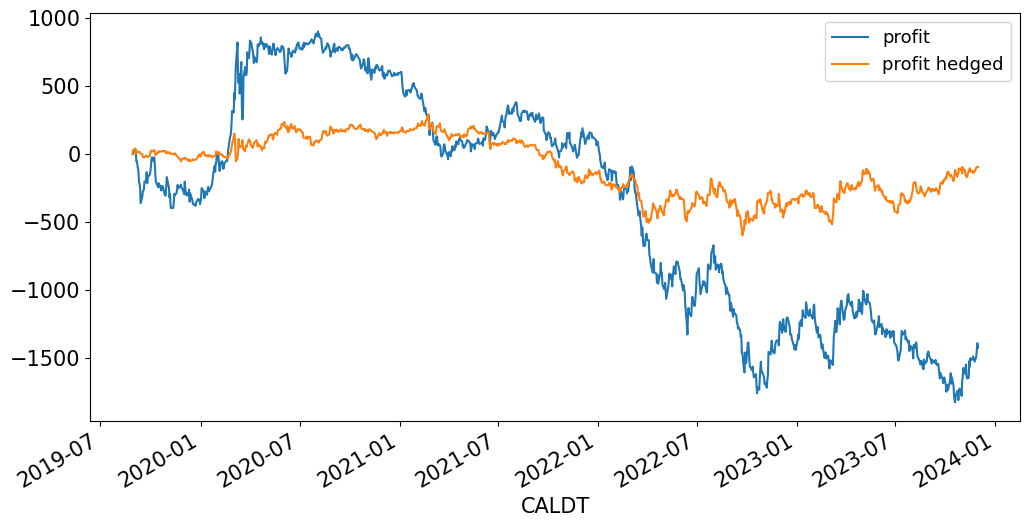

In [16]:
position[['profit','profit hedged']].cumsum().plot();

In [17]:
position[['profit','profit hedged']].describe().drop(index=['count']).style.format('${:,.2f}')

,profit,profit hedged
mean,$-1.34,$-0.09
std,$46.97,$21.78
min,$-321.11,$-98.32
25%,$-29.54,$-11.98
50%,$-2.40,$-0.44
75%,$25.43,$10.41
max,$276.19,$119.78


***

# 3 Calculating Duration Via Individual Cashflows

## *Optional*

***No need to submit this problem, but if we discuss it, then you are expected to know it.***

Use the data file `../data/treasury_quotes_2023-07-26.xlsx`.

This data reports duration as `TDDURATN`. It quotes the duration in days, so I recommend dividing by 365 to get the duration in its usual format.

## 3.1 
Set up the cashflow matrix. 


## 3.2
Build a discount curve assuming that the spot rate is 2\% per year, continuously compounded.

Plot the discount curve and the associated spot curve out to 30 years maturity.

*Note, you do not need to properly extract a spot curve and associated discount factors; rather, you are simply assuming a flat term structure of spot rates at 2\% and using that to figure out discount rates.*

## 3.3
For each treasury issue, calculate the duration as the weighted average of the (discounted!) cashflow maturity.

Report the summary statistics of the durations. (Use `.describe()` from pandas.)


## 3.4
How close are your duration estimates to the imputed durations given in the data source, (column `TDDURATN`)?

Report the summary statistics of the imputed durations minus your calculated durations from above.

Why might they be different?

## 3.5
Continue using your assumed discount rates of 2\% to calculate the convexity of each issue.

Report the summary statistics of these convexity calculations.

## 3.6

Re-do the duration and convexity calculations using an extracted discount curve instead of a discount curve based on a constant (arbitrary) spot rate. 

***

# <span style="color:red">Solution 3</span>

## 3.1

In [2]:
QUOTE_DATE = '2023-07-26'
filepath_rawdata = f'../data/treasury_quotes_{QUOTE_DATE}.xlsx'
rawdata = pd.read_excel(filepath_rawdata,sheet_name='quotes')
rawdata.columns = rawdata.columns.str.upper()
rawdata.sort_values('TMATDT',inplace=True)
rawdata.set_index('KYTREASNO',inplace=True)

t_check = rawdata['CALDT'].values[0]
if rawdata['CALDT'].eq(t_check).all():
    t_current = t_check
else:
    warnings.warn('Quotes are from multiple dates.')
    t_current = None

rawprices = (rawdata['TDBID'] + rawdata['TDASK'])/2 + rawdata['TDACCINT']
rawprices.name = 'price'

maturity_delta = get_maturity_delta(rawdata['TMATDT'],t_current)
maturity_delta.name = 'maturity delta'
display(f'Treasuries quoted on {QUOTE_DATE}.')

'Treasuries quoted on 2023-07-26.'

In [3]:
MODEL = nelson_siegel

RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = False
RESTRICT_REDUNDANT = False

data = filter_treasuries(rawdata, t_date=t_current, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)
CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)

CF

,2023-07-27,2023-07-31,2023-08-01,2023-08-03,2023-08-08,2023-08-10,2023-08-15,2023-08-17,2023-08-22,2023-08-24,...,2051-09-15,2051-11-15,2052-02-15,2052-03-15,2052-05-15,2052-08-15,2052-09-15,2052-11-15,2053-02-15,2053-03-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207997,100,0.0000,0,0,0,0,0.0000,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000
207231,0,101.3750,0,0,0,0,0.0000,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000
207742,0,100.0625,0,0,0,0,0.0000,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000
206998,0,100.6250,0,0,0,0,0.0000,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000
208025,0,0.0000,100,0,0,0,0.0000,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207891,0,0.0000,0,0,0,0,0.0000,0,0,0,...,0.0000,1.4375,0.0000,0.0000,101.4375,0.0000,0.0000,0,0.0000,0.0000
207934,0,0.0000,0,0,0,0,1.5000,0,0,0,...,0.0000,0.0000,1.5000,0.0000,0.0000,101.5000,0.0000,0,0.0000,0.0000
207977,0,0.0000,0,0,0,0,0.0000,0,0,0,...,0.0000,2.0000,0.0000,0.0000,2.0000,0.0000,0.0000,102,0.0000,0.0000


## 3.2

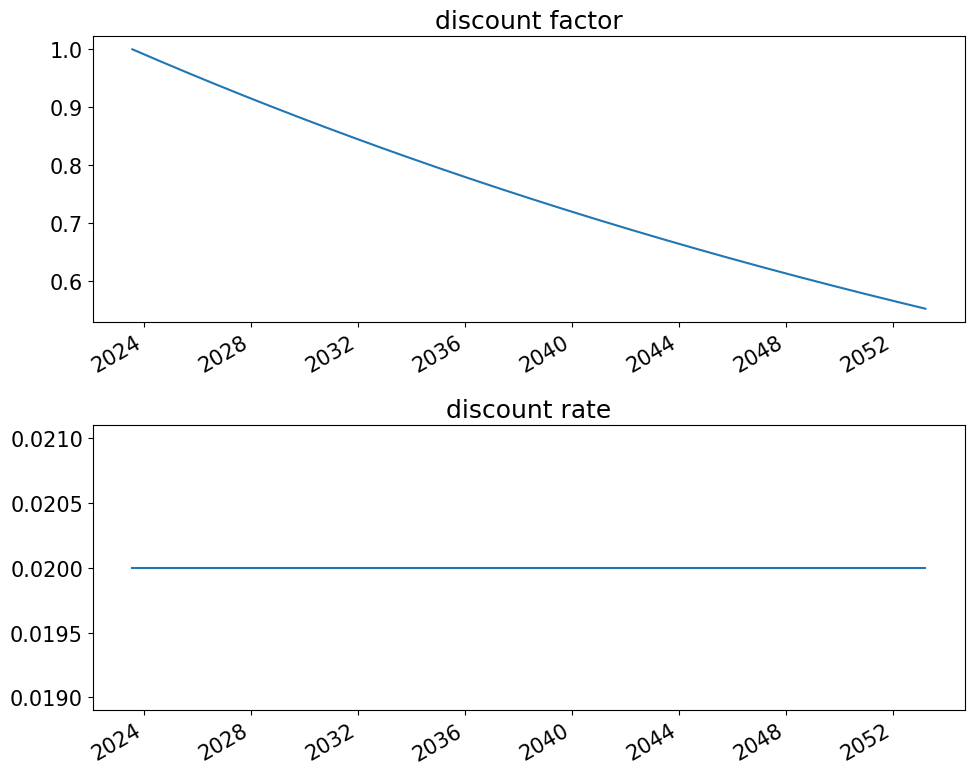

In [4]:
RATE = .02
maturity_grid = pd.Series(get_maturity_delta(CF.columns.values,t_current=t_current),index=CF.columns)
discount_factors = np.exp(-RATE * maturity_grid)

curves = pd.DataFrame(discount_factors,index=CF.columns, columns=['discount factor'])
curves['discount rate'] = RATE

fig,ax = plt.subplots(2,1,figsize=(10,8))
curves['discount factor'].plot(ax=ax[0],title='discount factor');
curves['discount rate'].plot(ax=ax[1],title = 'discount rate');
plt.tight_layout()

## 3.3

In [5]:
wts = CF.mul(curves['discount factor'],axis=1)
wts = wts.div(wts.sum(axis=1),axis=0)
duration = (wts @ maturity_grid.to_frame()).rename(columns={0:'duration'})

## 3.4

In [6]:
FREQ = 365.25
duration['errors'] = rawdata['TDDURATN']/FREQ  - duration['duration']

## 3.5

In [7]:
duration['convexity'] = wts @ maturity_grid**2

## Show answers

In [8]:
duration.describe()

,duration,errors,convexity
count,386.000000,386.000000,386.000000
mean,5.152346,-0.223728,72.743346
std,5.987354,0.486523,137.982353
min,0.002738,-2.137113,0.000007
25%,0.897753,-0.045502,0.807328
50%,2.744812,-0.003155,7.708242
75%,5.827926,-0.000062,36.824040
max,22.349840,0.060562,564.669534


***

# 4 Other Interest-Rate Risks

## *Optional*

***No need to submit this problem, but if we discuss it, then you are expected to know it.***

## 4.1 Other Yield Curve Movements

Use the yield curve time-series data in `'../data/yields.xlsx` to calculate the time-series of the **level**, **slope**, and curvature** factors.

Calculate the yield-curve factors. For each point in time, calculate the following three factors:

$\begin{align}
x^{\text{level}}_t =& \frac{1}{N_{\text{yields}}}\sum_{i=1}^{N_{\text{yields}}} y^{(i)}_t\\
x^{\text{slope}}_t =& y^{(30)}_t - y^{(1)}_t\\
x^{\text{curvature}}_t =& -y^{(1)}_t + 2 y^{(10)}_t - y^{(30)}_t
\end{align}$

Report the mean and volatility of each factor.

Report the correlation matrix of the factors.

## 4.2 Factor Duration

Calculate the factor duration of the treasuries from `treasury_ts_issue_duration_(207392, 207391, 207457).xlsx`.

Run a multivariate regression of the bond prices on all three factors constructed above from the yield factors: level, slope, and curvature. 

Estimate the regression in the form of day-over-day differences for both bond prices and factors. That is, we are using regression to approximate the factor duration equation,

$\begin{align}
\frac{dP}{P} = \beta_1 dz_1 + \beta_2 dz_2 + \beta_3 dz_3 + \epsilon
\end{align}$

Report the betas for each of these factors, for each of the bond prices.

***

# <span style="color:red">Solution 4</span>

## <span style="color:red">Solution 4.1</span>

In [18]:
filepath = '../data/yields.xlsx'
yields = pd.read_excel(filepath, sheet_name='yields')
yields.set_index('caldt',inplace=True)

shapes = pd.DataFrame(yields.mean(axis=1),columns=['level'])
shapes['slope'] = yields[30]-yields[1]
shapes['curvature'] = -yields[1] + 2 * yields[10] - yields[30]

DATETHRESH = '2010-01-01'
shapesT = shapes[shapes.index>DATETHRESH]

In [19]:
shapes.describe()

,level,slope,curvature
count,15598.000000,15598.000000,15598.000000
mean,5.483636,1.123415,0.684435
std,2.924812,1.478283,0.965407
min,0.487603,-3.490292,-5.426753
25%,3.420522,0.013197,0.113819
50%,5.220376,1.024885,0.632046
75%,7.183622,2.138393,1.343578
max,15.259628,4.358273,3.283792


In [20]:
shapes.corr()

,level,slope,curvature
level,1.000000,-0.381529,-0.176025
slope,-0.381529,1.000000,0.642917
curvature,-0.176025,0.642917,1.000000


### since 2010

In [21]:
shapesT.describe()

,level,slope,curvature
count,3484.000000,3484.000000,3484.000000
mean,2.051995,1.889831,0.501776
std,0.891231,1.395169,0.846758
min,0.487603,-1.552133,-1.738835
25%,1.483024,0.896827,-0.012975
50%,1.906134,1.974268,0.489931
75%,2.504338,2.929087,1.032403
max,5.084145,4.358273,2.612146


In [22]:
shapesT.corr()

,level,slope,curvature
level,1.000000,-0.477519,-0.285642
slope,-0.477519,1.000000,0.896645
curvature,-0.285642,0.896645,1.000000


## <span style="color:red">Solution 4.2</span>

Note that it makes little difference whether an intercept is included in this regression, and either is defensible. For the standardized version below, it will make no difference.

In [23]:
dp_pct = px.pct_change().dropna()
dfac = shapes.diff().dropna()
dp_pct, dfac = dp_pct.align(dfac,join='inner',axis=0)

factor_durations = pd.DataFrame(-LinearRegression(fit_intercept=True).fit(dfac,dp_pct).coef_, columns = dp_pct.columns, index= dfac.columns)
factor_durations

KYTREASNO,207391,207392,207404
level,0.073520,0.005672,0.010817
slope,0.206468,0.129728,-0.080094
curvature,0.022683,-0.003948,0.002627


#### Try standardizing the factors
The way we constructed level, slope, curvature, they may each have very different scalings (magnitudes,) which makes their betas hard to interpret. Easier to normalize them with a z-score, so that the resulting betas can be interpreted as the reaction to a one-sigma move in the factor.

In [24]:
def zscore(df):
    z = df.sub(df.mean(axis=0)).div(df.std(axis=0))
    return z

dz = zscore(dfac)

z_durations = pd.DataFrame(-LinearRegression(fit_intercept=True).fit(dz,dp_pct).coef_, columns = dp_pct.columns, index= dz.columns)
z_durations

KYTREASNO,207391,207392,207404
level,0.003957,0.000351,0.000685
slope,0.011113,0.008020,-0.005072
curvature,0.001221,-0.000244,0.000166
